# Read 1 sample data from api

In [1]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
API_KEY = os.getenv('NASA_API_KEY')

# Define the API endpoint
BASE_URL = "https://api.nasa.gov/neo/rest/v1/neo/browse"

# Parameters for the request
params = {
    'api_key': API_KEY
}

# Make the request
response = requests.get(BASE_URL, params=params)

# Check if the response is successful
if response.status_code == 200:
    data = response.json()
    # Get the first sample data
    sample_data = data['near_earth_objects'][0]
    
    # Display the sample data
    print("Sample Data:", sample_data)
else:
    print(f"Error: {response.status_code} - {response.text}")


Sample Data: {'links': {'self': 'http://api.nasa.gov/neo/rest/v1/neo/2000433?api_key=zcxQwdC4yrrcxa5zdJgZ3cjWUyZR23QXtaJ8JZdO'}, 'id': '2000433', 'neo_reference_id': '2000433', 'name': '433 Eros (A898 PA)', 'name_limited': 'Eros', 'designation': '433', 'nasa_jpl_url': 'https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=2000433', 'absolute_magnitude_h': 10.41, 'estimated_diameter': {'kilometers': {'estimated_diameter_min': 22.0067027115, 'estimated_diameter_max': 49.2084832235}, 'meters': {'estimated_diameter_min': 22006.7027114738, 'estimated_diameter_max': 49208.4832234845}, 'miles': {'estimated_diameter_min': 13.6743268705, 'estimated_diameter_max': 30.5767244291}, 'feet': {'estimated_diameter_min': 72200.4705239119, 'estimated_diameter_max': 161445.1600989368}}, 'is_potentially_hazardous_asteroid': False, 'close_approach_data': [{'close_approach_date': '1900-12-27', 'close_approach_date_full': '1900-Dec-27 01:30', 'epoch_date_close_approach': -2177879400000, 'relative_velocity':

In [2]:
import json

with open('sample_data.json', 'w') as f:
    json.dump(sample_data, f, indent=4)

# Handle batch data

In [3]:
# %%
# ## NASA NEO Data Collection Notebook
# This notebook-style script gathers data from NASA's Near Earth Object Web Service (NeoWs) API,
# processes the first 200 Near Earth Objects (NEOs), saves them in Parquet format,
# and computes required aggregations.

# %%
# 1. IMPORTS & CONFIGURATION
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

# Load API key from .env file
load_dotenv()
API_KEY = os.getenv("NASA_API_KEY")  # Ensure you have a .env with NASA_API_KEY=your_key
BASE_URL = "https://api.nasa.gov/neo/rest/v1/neo/browse"

# Define local data lake path (mimic S3 structure)
DATA_DIR = Path("data/neo")
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# %%
# 2. FUNCTION DEFINITIONS

def fetch_neo_page(page: int = 0, size: int = 20) -> dict:
    """
    Fetch one page of NEO browse results.
    :param page: zero-based page index
    :param size: number of NEOs per page (API default 20)
    :return: JSON response as dict
    """
    params = {
        'page': page,
        'size': size,
        'api_key': API_KEY
    }
    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()
    return response.json()


def parse_neo_record(record: dict) -> dict:
    """
    Extract required fields from a single NEO record.
    """
    # Basic fields
    out = {
        'id': record['id'],
        'neo_reference_id': record['neo_reference_id'],
        'name': record['name'],
        # name_limited: take the part after first space or full name if none
        'name_limited': record['name'].split()[-1] if ' ' in record['name'] else record['name'],
        'designation': record['designation'],
        'nasa_jpl_url': record['nasa_jpl_url'],
        'absolute_magnitude_h': record['absolute_magnitude_h'],
        'is_potentially_hazardous_asteroid': record['is_potentially_hazardous_asteroid'],
        # estimated diameter in meters
        'est_diam_min_m': record['estimated_diameter']['meters']['estimated_diameter_min'],
        'est_diam_max_m': record['estimated_diameter']['meters']['estimated_diameter_max']
    }
    
    # Check if close_approach_data is empty
    if record['close_approach_data']:
        # Find the closest approach data entry (minimum miss_distance.kilometers)
        cad = min(
            record['close_approach_data'],
            key=lambda x: float(x['miss_distance']['kilometers'])
        )
        out.update({
            'close_approach_date': cad['close_approach_date'],
            'miss_distance_km': float(cad['miss_distance']['kilometers']),
            'miss_distance_au': float(cad['miss_distance']['astronomical']),
            'relative_velocity_kps': float(cad['relative_velocity']['kilometers_per_second'])
        })
    else:
        # Handle case where no close approach data exists
        out.update({
            'close_approach_date': None,
            'miss_distance_km': None,
            'miss_distance_au': None,
            'relative_velocity_kps': None
        })
    
    # Orbital data
    orb = record['orbital_data']
    out.update({
        'first_observation_date': orb['first_observation_date'],
        'last_observation_date': orb['last_observation_date'],
        'observations_used': orb['observations_used'],
        'orbital_period': float(orb['orbital_period'])
    })
    return out


def collect_neos(limit: int = 200) -> pd.DataFrame:
    """
    Collect up to `limit` NEOs by paging through API.
    Returns a DataFrame of parsed records.
    """
    records = []
    page, size = 0, 20
    while len(records) < limit:
        data = fetch_neo_page(page, size)
        neos = data['near_earth_objects']
        for rec in neos:
            if len(records) >= limit:
                break
            records.append(parse_neo_record(rec))
        page += 1
    return pd.DataFrame(records)


def save_to_parquet(df: pd.DataFrame, path: Path):
    """
    Save DataFrame to Parquet file at given path, excluding miss_distance_au column.
    """
    # Create a copy of the DataFrame without the miss_distance_au column
    save_df = df.drop(columns=['miss_distance_au'], errors='ignore')
    save_df.to_parquet(path, index=False)


def compute_aggregations(df: pd.DataFrame) -> dict:
    """
    Compute required aggregations:
      - total approaches closer than 0.2 AU
      - number of close approaches per year
    """
    # Count of records with miss_distance_au < 0.2
    total_close = (df['miss_distance_au'] < 0.2).sum()
    # Extract year from close_approach_date and ensure it's an integer
    df['approach_year'] = pd.to_datetime(df['close_approach_date'], errors='coerce').dt.year
    # Drop NaN years and convert to int
    df = df.dropna(subset=['approach_year'])
    df['approach_year'] = df['approach_year'].astype(int)
    counts_per_year = df['approach_year'].value_counts().sort_index().to_dict()
    return {
        'total_approaches_lt_0.2_AU': int(total_close),
        'approaches_per_year': counts_per_year
    }

In [5]:
# 3. DATA COLLECTION
# Fetch first 20 NEOs as experiment and create DataFrame
neo_df = collect_neos(limit=200)
print(f"Collected {len(neo_df)} NEO records.")
neo_df.head()

Collected 200 NEO records.


,id,neo_reference_id,name,name_limited,designation,nasa_jpl_url,absolute_magnitude_h,is_potentially_hazardous_asteroid,est_diam_min_m,est_diam_max_m,close_approach_date,miss_distance_km,miss_distance_au,relative_velocity_kps,first_observation_date,last_observation_date,observations_used,orbital_period
0,2000433,2000433,433 Eros (A898 PA),PA),433,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,10.41,False,22006.702711,49208.483223,2137-01-25,2.235924e+07,0.149462,5.814276,1893-10-29,2021-05-13,9130,643.140314
1,2000719,2000719,719 Albert (A911 TB),TB),719,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,15.59,False,2025.606009,4529.392731,2110-11-08,2.079343e+08,1.389955,3.467001,1911-10-04,2025-03-28,2102,1563.523277
2,2000887,2000887,887 Alinda (A918 AA),AA),887,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,13.81,False,4597.851883,10281.109360,2025-01-08,1.229661e+07,0.082198,8.248699,1918-02-09,2025-05-16,5457,1420.708889
3,2001036,2001036,1036 Ganymed (A924 UB),UB),1036,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,9.18,False,38775.283038,86704.168720,2176-12-16,4.290993e+06,0.028684,15.749851,1924-10-23,2025-04-18,12602,1589.790693
4,2001221,2001221,1221 Amor (1932 EA1),EA1),1221,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,17.37,False,892.390579,1995.445996,1940-03-22,1.574922e+07,0.105277,8.368423,1932-03-12,2025-02-19,686,971.558582


In [6]:
# %%
# 4. SAVE DATA
# Save full DataFrame to Parquet
parquet_path = DATA_DIR / "neos_200.parquet"
save_to_parquet(neo_df, parquet_path)
print(f"Data saved to: {parquet_path}")

Data saved to: data/neo/neos_200.parquet


In [7]:
# %%
# 5. COMPUTE AGGREGATIONS
aggs = compute_aggregations(neo_df)
print("Total approaches < 0.2 AU:", aggs['total_approaches_lt_0.2_AU'])
print("Approaches per year:")
for year, count in aggs['approaches_per_year'].items():
    print(f"  {year}: {count}")

# Optionally save aggregations as JSON
agg_path = DATA_DIR / "aggregations.json"
import json
with open(agg_path, 'w') as f:
    json.dump(aggs, f, indent=2)
print(f"Aggregations saved to: {agg_path}")



Total approaches < 0.2 AU: 174
Approaches per year:
  1902: 1
  1904: 2
  1905: 1
  1906: 1
  1907: 1
  1909: 1
  1911: 1
  1916: 2
  1920: 1
  1923: 2
  1924: 2
  1925: 2
  1927: 1
  1929: 1
  1930: 1
  1932: 1
  1933: 2
  1934: 1
  1936: 1
  1940: 1
  1947: 1
  1949: 1
  1950: 1
  1958: 1
  1962: 1
  1964: 4
  1967: 2
  1968: 1
  1969: 1
  1970: 1
  1972: 2
  1976: 2
  1978: 2
  1979: 2
  1980: 2
  1981: 1
  1982: 1
  1986: 1
  1989: 3
  1990: 1
  1991: 4
  1992: 1
  1993: 1
  1994: 3
  1996: 2
  2000: 2
  2001: 1
  2003: 1
  2004: 1
  2011: 1
  2014: 1
  2015: 1
  2017: 1
  2019: 1
  2020: 2
  2022: 1
  2023: 1
  2025: 1
  2026: 2
  2029: 1
  2031: 1
  2032: 2
  2035: 2
  2041: 1
  2042: 1
  2045: 1
  2046: 1
  2048: 1
  2050: 1
  2053: 2
  2055: 1
  2058: 1
  2059: 1
  2060: 1
  2067: 2
  2068: 1
  2070: 1
  2074: 1
  2075: 2
  2076: 1
  2083: 1
  2084: 2
  2085: 1
  2086: 1
  2091: 2
  2092: 2
  2093: 1
  2097: 2
  2099: 1
  2101: 1
  2104: 1
  2106: 1
  2107: 1
  2110: 1
  2118: 

/var/folders/r7/r31rg0y91fnd4b5mjpy66l3m0000gn/T/ipykernel_55941/933078948.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['approach_year'] = df['approach_year'].astype(int)


In [ ]:
# %%
# 6. NEXT STEPS
# - Extend `fetch_neo_page` to handle retries or backoff for large-scale
# - Swap out In-Memory DataFrame for chunked processing if dataset grows to GBs
# - Integrate with actual S3 connector (e.g., boto3) by changing save functions
# - Schedule this notebook/script as a job using Airflow or cron

In [4]:
# verify if the data is saved correctly
import pandas as pd
df = pd.read_parquet('../data/neo/manual_200.parquet')
print(f"Number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

Number of records: 200
Columns: ['id', 'neo_reference_id', 'name', 'name_limited', 'designation', 'nasa_jpl_url', 'absolute_magnitude_h', 'is_potentially_hazardous_asteroid', 'est_diam_min_m', 'est_diam_max_m', 'close_approach_date', 'miss_distance_km', 'relative_velocity_kps', 'first_observation_date', 'last_observation_date', 'observations_used', 'orbital_period']


,id,neo_reference_id,name,name_limited,designation,nasa_jpl_url,absolute_magnitude_h,is_potentially_hazardous_asteroid,est_diam_min_m,est_diam_max_m,close_approach_date,miss_distance_km,relative_velocity_kps,first_observation_date,last_observation_date,observations_used,orbital_period
0,2000433,2000433,433 Eros (A898 PA),PA),433,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,10.41,False,22006.702711,49208.483223,2137-01-25,2.235924e+07,5.814276,1893-10-29,2021-05-13,9130,643.140314
1,2000719,2000719,719 Albert (A911 TB),TB),719,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,15.59,False,2025.606009,4529.392731,2110-11-08,2.079343e+08,3.467001,1911-10-04,2025-03-28,2102,1563.523277
2,2000887,2000887,887 Alinda (A918 AA),AA),887,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,13.81,False,4597.851883,10281.109360,2025-01-08,1.229661e+07,8.248699,1918-02-09,2025-05-16,5457,1420.708889
3,2001036,2001036,1036 Ganymed (A924 UB),UB),1036,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,9.18,False,38775.283038,86704.168720,2176-12-16,4.290993e+06,15.749851,1924-10-23,2025-04-18,12602,1589.790693
4,2001221,2001221,1221 Amor (1932 EA1),EA1),1221,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,17.37,False,892.390579,1995.445996,1940-03-22,1.574922e+07,8.368423,1932-03-12,2025-02-19,686,971.558582


# NEO Data Analysis and Visualization

In this section, we'll perform an in-depth analysis of the Near Earth Object (NEO) data we've collected from NASA's API. We'll explore:
1. Basic data statistics and structure
2. Column meanings and distributions
3. Correlations between features
4. Potential machine learning applications

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error

# Set up visualization preferences
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
plt.rcParams['figure.figsize'] = (14, 8)  # Larger figures
sns.set_palette('viridis')  # Good color palette for scientific data

# 1. Load the data
print("Loading NEO data from parquet file...")
try:
    neo_df = pd.read_parquet('../data/neo/manual_200.parquet')
    print(f"Successfully loaded {len(neo_df)} NEO records")
except Exception as e:
    print(f"Error loading data: {e}")
    # Try alternate path if the first one fails
    try:
        neo_df = pd.read_parquet('./data/neo/manual_200.parquet')
        print(f"Successfully loaded {len(neo_df)} NEO records using alternate path")
    except Exception as e2:
        print(f"Error loading data with alternate path: {e2}")
        neo_df = pd.DataFrame()

print(neo_df.head())

Loading NEO data from parquet file...
Successfully loaded 200 NEO records
        id neo_reference_id                    name name_limited designation   
0  2000433          2000433      433 Eros (A898 PA)          PA)         433  \
1  2000719          2000719    719 Albert (A911 TB)          TB)         719   
2  2000887          2000887    887 Alinda (A918 AA)          AA)         887   
3  2001036          2001036  1036 Ganymed (A924 UB)          UB)        1036   
4  2001221          2001221    1221 Amor (1932 EA1)         EA1)        1221   

                                        nasa_jpl_url  absolute_magnitude_h   
0  https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...                 10.41  \
1  https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...                 15.59   
2  https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...                 13.81   
3  https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...                  9.18   
4  https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...   

In [2]:
# 2. Basic data understanding
print("\n===== BASIC DATA OVERVIEW =====")

# Display basic information about the DataFrame
print("\nDataFrame Info:")
neo_df.info()

# Display basic statistics
print("\nBasic Statistics:")
display(neo_df.describe())

# Check for missing values
print("\nMissing Values by Column:")
missing_data = neo_df.isnull().sum()
print(missing_data[missing_data > 0])

# Display column names and a sample row to understand the data
print("\nColumn Names and Data Types:")
for col in neo_df.columns:
    print(f"{col}: {neo_df[col].dtype}")

print("\nSample NEO Record:")
display(neo_df.iloc[0])


===== BASIC DATA OVERVIEW =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 200 non-null    object 
 1   neo_reference_id                   200 non-null    object 
 2   name                               200 non-null    object 
 3   name_limited                       200 non-null    object 
 4   designation                        200 non-null    object 
 5   nasa_jpl_url                       200 non-null    object 
 6   absolute_magnitude_h               200 non-null    float64
 7   is_potentially_hazardous_asteroid  200 non-null    bool   
 8   est_diam_min_m                     200 non-null    float64
 9   est_diam_max_m                     200 non-null    float64
 10  close_approach_date                185 non-null    object 
 11  miss_dis

,absolute_magnitude_h,est_diam_min_m,est_diam_max_m,miss_distance_km,relative_velocity_kps,observations_used,orbital_period
count,200.000000,200.000000,200.000000,1.850000e+02,185.000000,200.000000,200.000000
mean,16.421950,1987.519061,4444.227726,1.310806e+07,14.414522,2461.120000,956.818819
std,1.650421,3253.534923,7275.125255,2.300070e+07,7.137945,2488.625201,416.298556
min,9.180000,189.040552,422.707525,6.802567e+05,2.487432,55.000000,277.197704
25%,15.330000,885.243466,1979.464567,4.256581e+06,9.616478,954.750000,642.536244
50%,16.480000,1344.496208,3006.384917,8.162838e+06,13.310027,1613.500000,907.490556
75%,17.387500,2283.330798,5105.682879,1.404838e+07,17.439048,2826.500000,1220.018198
max,20.740000,38775.283038,86704.168720,2.079343e+08,38.114652,14321.000000,3221.085542



Missing Values by Column:
close_approach_date      15
miss_distance_km         15
relative_velocity_kps    15
dtype: int64

Column Names and Data Types:
id: object
neo_reference_id: object
name: object
name_limited: object
designation: object
nasa_jpl_url: object
absolute_magnitude_h: float64
is_potentially_hazardous_asteroid: bool
est_diam_min_m: float64
est_diam_max_m: float64
close_approach_date: object
miss_distance_km: float64
relative_velocity_kps: float64
first_observation_date: object
last_observation_date: object
observations_used: int64
orbital_period: float64

Sample NEO Record:


id                                                                             2000433
neo_reference_id                                                               2000433
name                                                                433 Eros (A898 PA)
name_limited                                                                       PA)
designation                                                                        433
nasa_jpl_url                         https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...
absolute_magnitude_h                                                             10.41
is_potentially_hazardous_asteroid                                                False
est_diam_min_m                                                            22006.702711
est_diam_max_m                                                            49208.483223
close_approach_date                                                         2137-01-25
miss_distance_km                           

## Column Explanations

Understanding the NEO data structure:

1. **ID & Reference Columns**:
   - `id`: NASA's unique identifier for the NEO
   - `neo_reference_id`: The NEO's reference ID in NASA's catalog
   - `name`: Full name of the NEO
   - `name_limited`: Simplified name (part after space, or full name if no space)
   - `designation`: Technical designation of the NEO
   - `nasa_jpl_url`: URL to the NASA JPL page for this object

2. **Physical Characteristics**:
   - `absolute_magnitude_h`: Astronomical brightness measure; lower values indicate larger objects
   - `est_diam_min_m` & `est_diam_max_m`: Estimated minimum/maximum diameter in meters
   - `is_potentially_hazardous_asteroid`: Boolean indicating potential hazard status

3. **Orbital & Approach Data**:
   - `close_approach_date`: Date of closest approach to Earth
   - `miss_distance_km`: Closest approach distance in kilometers
   - `miss_distance_au`: Closest approach distance in astronomical units (1 AU = distance from Earth to Sun)
   - `relative_velocity_kps`: Speed relative to Earth in kilometers per second
   - `first_observation_date` & `last_observation_date`: Timespan of observations
   - `observations_used`: Number of observations used to calculate orbit
   - `orbital_period`: Time to complete one orbit (in days)


===== DATA VISUALIZATIONS =====


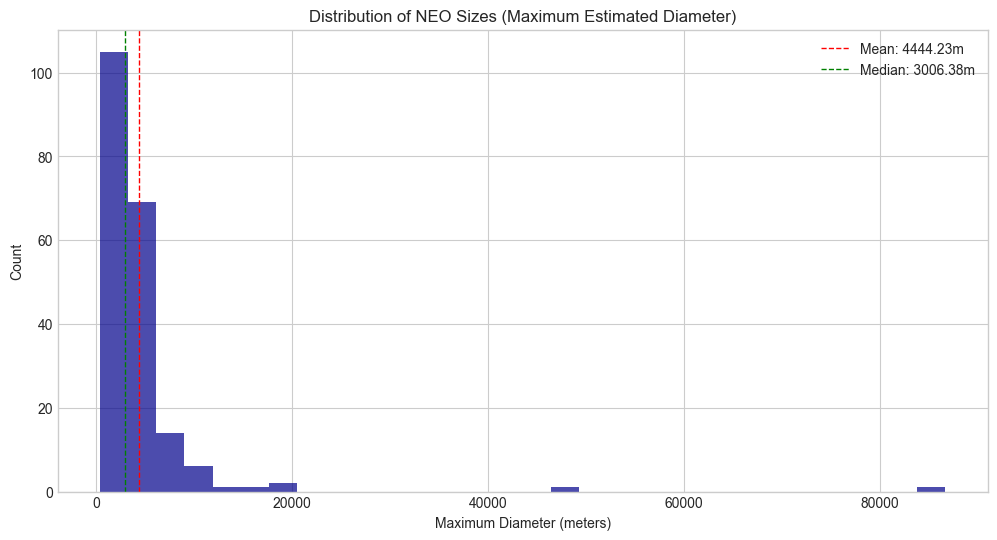

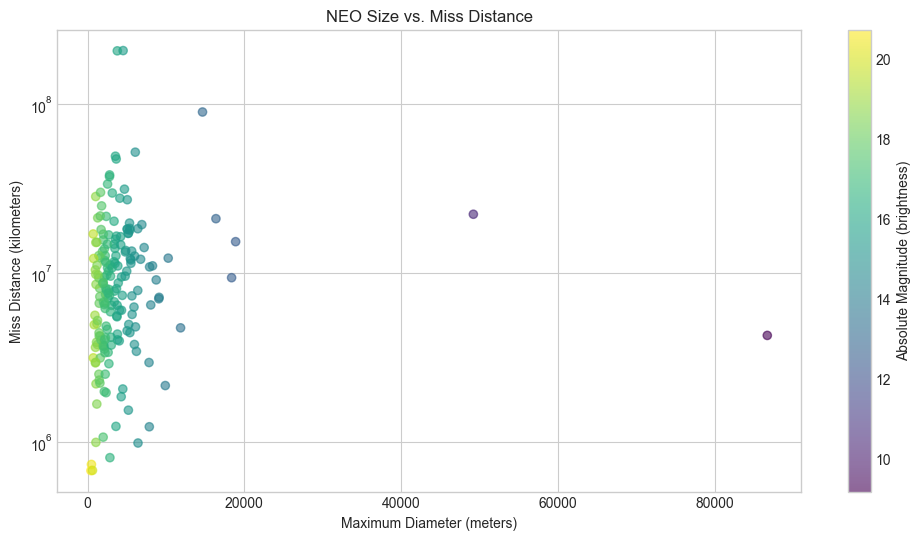

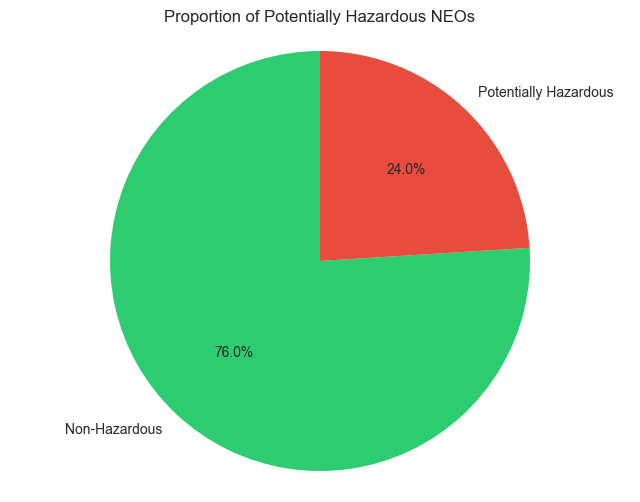

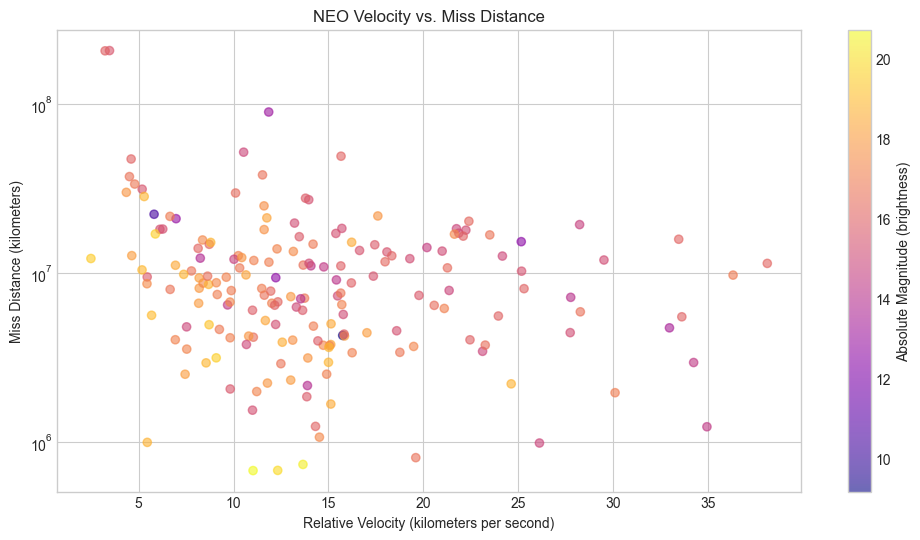

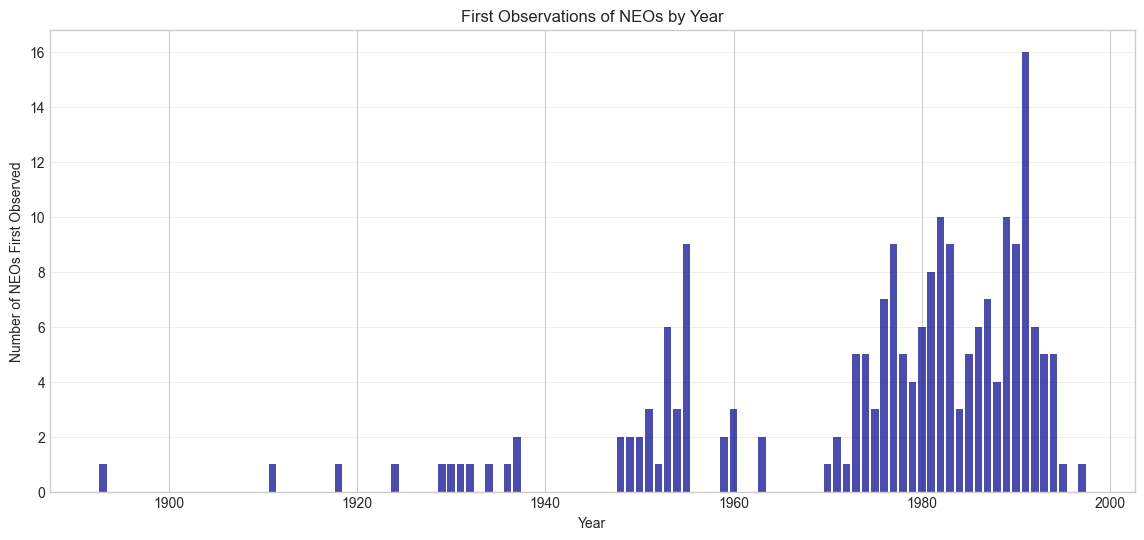

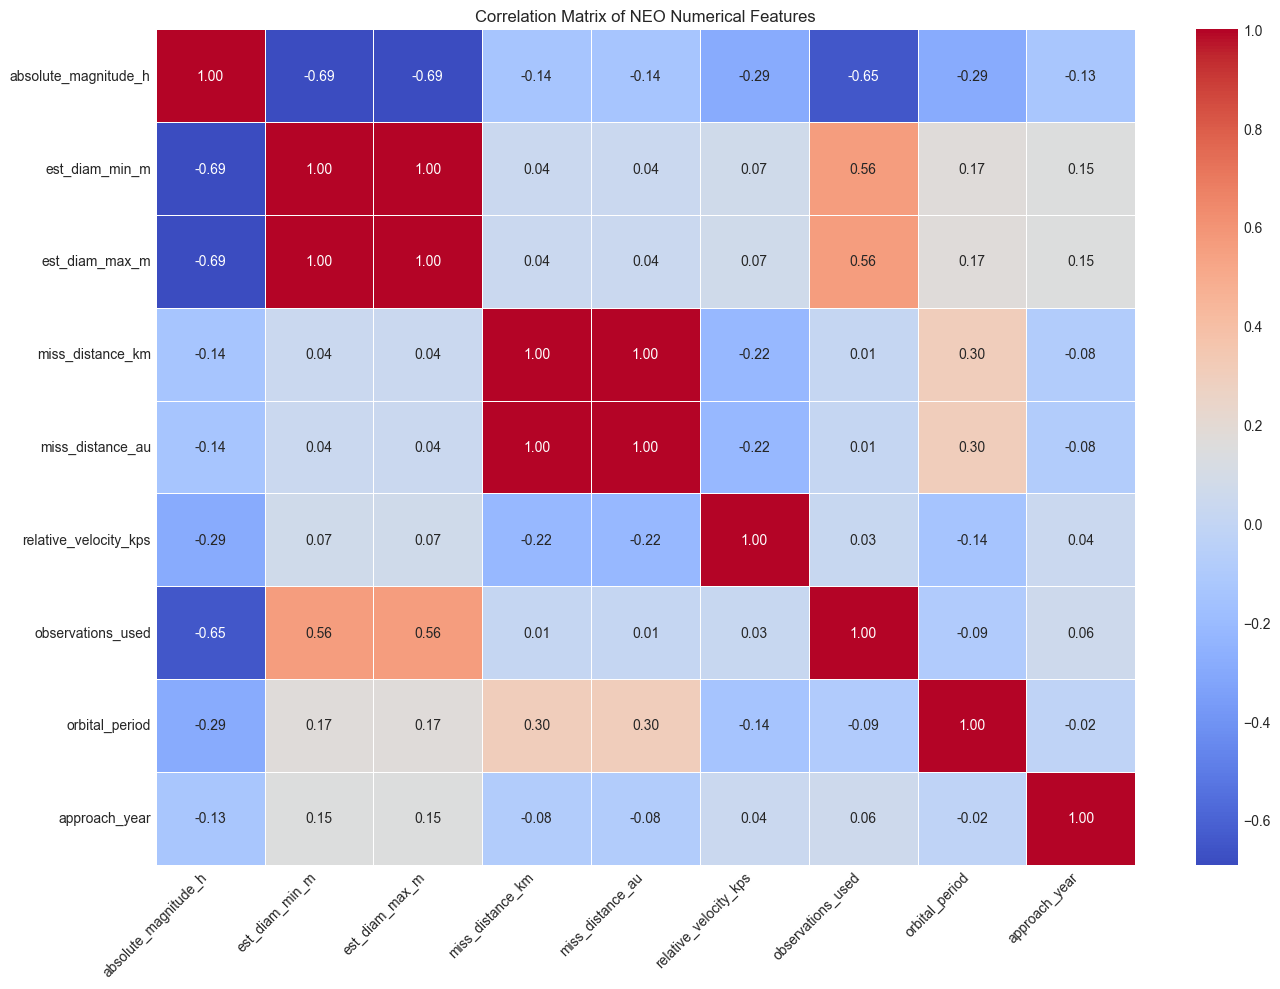

In [8]:
# 3. Data visualizations
if not neo_df.empty:
    print("\n===== DATA VISUALIZATIONS =====")
    
    # 3.1 Histogram of asteroid sizes
    plt.figure(figsize=(12, 6))
    plt.hist(neo_df['est_diam_max_m'], bins=30, alpha=0.7, color='darkblue')
    plt.title('Distribution of NEO Sizes (Maximum Estimated Diameter)')
    plt.xlabel('Maximum Diameter (meters)')
    plt.ylabel('Count')
    plt.axvline(neo_df['est_diam_max_m'].mean(), color='red', linestyle='dashed', 
                linewidth=1, label=f"Mean: {neo_df['est_diam_max_m'].mean():.2f}m")
    plt.axvline(neo_df['est_diam_max_m'].median(), color='green', linestyle='dashed', 
                linewidth=1, label=f"Median: {neo_df['est_diam_max_m'].median():.2f}m")
    plt.legend()
    plt.show()
    
    # 3.2 Scatter plot: Size vs. Miss Distance
    plt.figure(figsize=(12, 6))
    plt.scatter(neo_df['est_diam_max_m'], neo_df['miss_distance_km'], 
               alpha=0.6, c=neo_df['absolute_magnitude_h'], cmap='viridis')
    plt.colorbar(label='Absolute Magnitude (brightness)')
    plt.title('NEO Size vs. Miss Distance')
    plt.xlabel('Maximum Diameter (meters)')
    plt.ylabel('Miss Distance (kilometers)')
    plt.yscale('log')  # Log scale for better visualization
    plt.show()
    
    # 3.3 Potentially hazardous asteroids
    hazard_counts = neo_df['is_potentially_hazardous_asteroid'].value_counts()
    plt.figure(figsize=(8, 6))
    plt.pie(hazard_counts, labels=['Non-Hazardous', 'Potentially Hazardous'] if hazard_counts.index[0] == False else ['Potentially Hazardous', 'Non-Hazardous'],
           autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
    plt.title('Proportion of Potentially Hazardous NEOs')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()
    
    # 3.4 Velocity vs. Miss Distance
    plt.figure(figsize=(12, 6))
    plt.scatter(neo_df['relative_velocity_kps'], neo_df['miss_distance_km'], 
               alpha=0.6, c=neo_df['absolute_magnitude_h'], cmap='plasma')
    plt.colorbar(label='Absolute Magnitude (brightness)')
    plt.title('NEO Velocity vs. Miss Distance')
    plt.xlabel('Relative Velocity (kilometers per second)')
    plt.ylabel('Miss Distance (kilometers)')
    plt.yscale('log')  # Log scale for better visualization
    plt.show()
    
    # 3.5 Time series: Observations over time
    neo_df['first_observation_date'] = pd.to_datetime(neo_df['first_observation_date'])
    neo_df['first_observation_year'] = neo_df['first_observation_date'].dt.year
    
    yearly_counts = neo_df['first_observation_year'].value_counts().sort_index()
    plt.figure(figsize=(14, 6))
    plt.bar(yearly_counts.index, yearly_counts.values, color='darkblue', alpha=0.7)
    plt.title('First Observations of NEOs by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of NEOs First Observed')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # 3.6 Correlation heatmap of numerical features
    # Select only numeric columns
    numeric_cols = neo_df.select_dtypes(include=['float64', 'int64']).columns
    corr_matrix = neo_df[numeric_cols].corr()
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of NEO Numerical Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Machine Learning Potential

The NEO dataset offers several interesting machine learning opportunities:

### Classification Problems:
1. **Hazard Classification**: Predict whether a NEO is potentially hazardous based on its physical and orbital characteristics
2. **Size Classification**: Categorize NEOs into size groups (small, medium, large) based on other features

### Regression Problems:
1. **Miss Distance Prediction**: Predict how close a NEO will come to Earth based on its characteristics
2. **Velocity Prediction**: Predict the relative velocity of a NEO based on its orbital parameters
3. **Diameter Estimation**: Estimate a NEO's diameter from its absolute magnitude and other parameters

### Clustering:
1. **NEO Family Identification**: Group NEOs with similar characteristics
2. **Orbital Similarity**: Cluster NEOs by their orbital characteristics

Below, we'll explore some simple ML examples with this dataset.


===== MACHINE LEARNING EXAMPLES =====
Using 185 records for ML examples (after removing rows with missing values)

CLASSIFICATION TASK: Predicting potentially hazardous NEOs

Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.94      0.82        36
        True       0.78      0.35      0.48        20

    accuracy                           0.73        56
   macro avg       0.75      0.65      0.65        56
weighted avg       0.74      0.73      0.70        56


Feature Importance for Hazard Prediction:


,Feature,Importance
3,miss_distance_km,0.342205
6,orbital_period,0.146306
4,relative_velocity_kps,0.124857
5,observations_used,0.111446
1,est_diam_min_m,0.098229
2,est_diam_max_m,0.091687
0,absolute_magnitude_h,0.085270


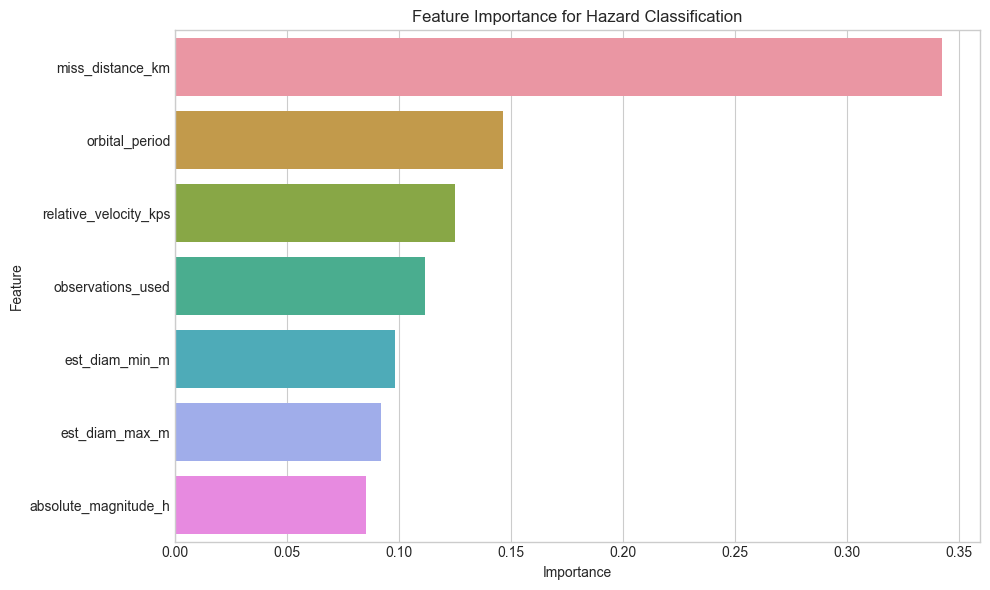


REGRESSION TASK: Predicting miss distance

Regression Performance:
Mean Squared Error: 155681858707421.88
Root Mean Squared Error: 12477253.65

Feature Importance for Miss Distance Prediction:


,Feature,Importance
3,relative_velocity_kps,0.484042
5,orbital_period,0.252223
4,observations_used,0.095958
0,absolute_magnitude_h,0.075506
1,est_diam_min_m,0.055339
2,est_diam_max_m,0.036932


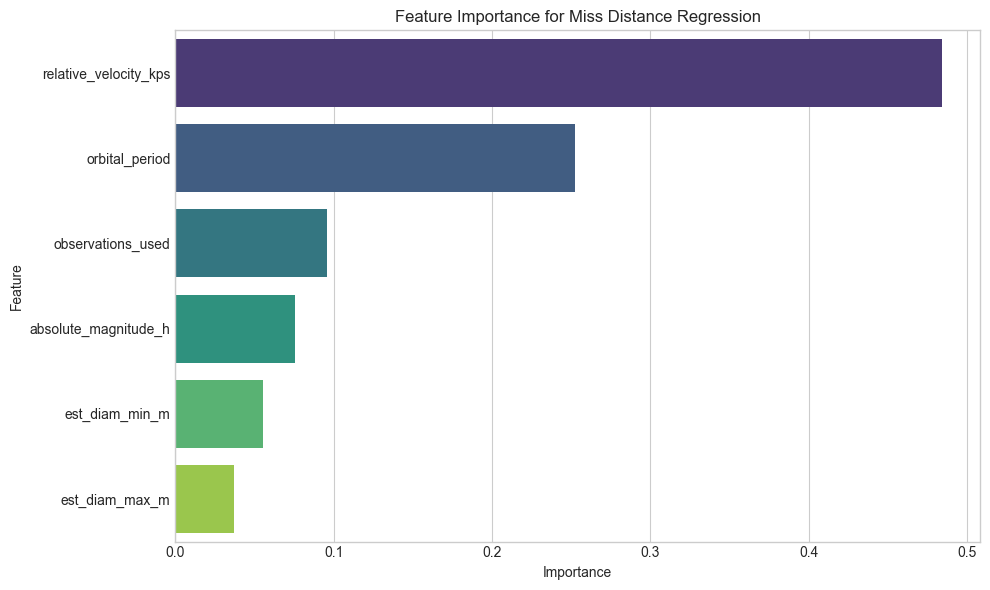

In [9]:
# 4. Machine Learning Examples
if not neo_df.empty:
    print("\n===== MACHINE LEARNING EXAMPLES =====")
    
    # Drop rows with missing values for ML
    ml_df = neo_df.dropna()
    print(f"Using {len(ml_df)} records for ML examples (after removing rows with missing values)")
    
    # Only use numeric columns for modeling
    feature_cols = [
        'absolute_magnitude_h', 'est_diam_min_m', 'est_diam_max_m',
        'miss_distance_km', 'relative_velocity_kps', 'observations_used',
        'orbital_period'
    ]
    
    # Make sure we only use columns that actually exist in the dataframe
    feature_cols = [col for col in feature_cols if col in ml_df.columns]
    
    if len(feature_cols) >= 3:  # Only proceed if we have enough features
        # 4.1 Classification Example: Predict potentially hazardous asteroids
        print("\nCLASSIFICATION TASK: Predicting potentially hazardous NEOs")
        
        # Prepare data
        X = ml_df[feature_cols]
        y = ml_df['is_potentially_hazardous_asteroid']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Train a Random Forest classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        
        # Make predictions and evaluate
        y_pred = clf.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': clf.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nFeature Importance for Hazard Prediction:")
        display(feature_importance)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('Feature Importance for Hazard Classification')
        plt.tight_layout()
        plt.show()
        
        # 4.2 Regression Example: Predict miss distance
        print("\nREGRESSION TASK: Predicting miss distance")
        
        # Prepare data - exclude miss_distance from features
        reg_features = [col for col in feature_cols if col != 'miss_distance_km']
        
        if len(reg_features) >= 3:
            X_reg = ml_df[reg_features]
            y_reg = ml_df['miss_distance_km']
            
            # Train-test split
            X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
                X_reg, y_reg, test_size=0.3, random_state=42)
            
            # Train a Random Forest regressor
            regr = RandomForestRegressor(n_estimators=100, random_state=42)
            regr.fit(X_train_reg, y_train_reg)
            
            # Make predictions and evaluate
            y_pred_reg = regr.predict(X_test_reg)
            mse = mean_squared_error(y_test_reg, y_pred_reg)
            rmse = np.sqrt(mse)
            
            print(f"\nRegression Performance:")
            print(f"Mean Squared Error: {mse:.2f}")
            print(f"Root Mean Squared Error: {rmse:.2f}")
            
            # Feature importance
            feature_importance_reg = pd.DataFrame({
                'Feature': reg_features,
                'Importance': regr.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            print("\nFeature Importance for Miss Distance Prediction:")
            display(feature_importance_reg)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_reg)
            plt.title('Feature Importance for Miss Distance Regression')
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough regression features available for modeling")
    else:
        print(f"Not enough features available for modeling. Found only {len(feature_cols)} usable features.")

## Conclusions and Recommendations

### Key Insights:
1. The NEO dataset provides valuable information about near-earth objects, including their size, orbit, velocity, and potential hazard status.
2. The data shows significant variation in object sizes, with most NEOs being relatively small but some reaching substantial diameters.
3. The correlation analysis reveals interesting relationships between features like absolute magnitude and diameter, as well as velocity and miss distance.

### Machine Learning Applications:
1. **Classification models** can effectively predict potentially hazardous NEOs using features like diameter, orbital characteristics, and velocity.
2. **Regression models** can estimate miss distances or other continuous parameters with reasonable accuracy.
3. **Time series analysis** could be applied to study trends in NEO discoveries and close approaches over time.

### Suggested Next Steps:
1. **Feature Engineering**: Create additional features like orbital eccentricity ratios or Earth-relative orbital parameters.
2. **Advanced Models**: Try deep learning approaches for complex pattern recognition or sequence models for trajectory prediction.
3. **Data Enrichment**: Combine this dataset with additional astronomical data sources for more comprehensive analysis.
4. **Real-time Predictions**: Develop a system to predict future close approaches based on current orbital parameters.

The NEO dataset offers rich opportunities for both scientific analysis and practical machine learning applications in astronomy and planetary defense.